<a href="https://colab.research.google.com/github/HauwaUmar/StockPrice-Hybrid-Model-/blob/main/Working%20Copy_of_Final_Assignment_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# Data Collection and Preprocessing


In [61]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process

#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.7 MB/s eta 0:00:00


Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 215 (delta 72), reused 73 (delta 30), pack-reused 68
Receiving objects: 100% (215/215), 5.93 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (96/96), done.


## Creation of Data Collection Functions

In [62]:
# functions to Retrieve financial info and feature engineer
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

#Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

#Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

#Final preprocessing and rolling averages feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'].shift(-1))
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


In [63]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)
print(full_finance.head(20))

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1419 non-null   datetime64[ns]
 1   open       1419 non-null   float64       
 2   high       1419 non-null   float64       
 3   low        1419 non-null   float64       
 4   close      1419 non-null   float64       
 5   adj_close  1419 non-null   float64       
 6   volume     1419 non-null   int64         
 7   ticker     1419 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 88.8+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

# Single Company Model Implementation
This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## EDA, Data Cleaning and Model Building
All data collection and initial prep is completed at this point.

In [64]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
  #check for outstanding NA values
  print(df['score'].isna().sum())
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

0
0
0
0
0
             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


### Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [65]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)

print(sentiment_dfs[1].info())
print(df_list[1].info())
#create final dataframe with sentiment included
goog = pd.merge(df_list[1], sentiment_dfs[1], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
msft = pd.merge(df_list[0], sentiment_dfs[0], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
amzn = pd.merge(df_list[2], sentiment_dfs[2], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
tesla = pd.merge(df_list[3], sentiment_dfs[3], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
nflx = pd.merge(df_list[4], sentiment_dfs[4], how = 'inner').set_index('date').loc['2018-01-01':'2023-02-01']
print(goog.info())
frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-65-8e39b6942336>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-65-8e39b6942336>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-65-8e39b6942336>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1410 non-null   datetime64[ns]
 1   score   1410 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1419 entries, 1419 to 2837
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1419 non-null   datetime64[ns]
 1   open        1419 non-null   float64       
 2   high        1419 non-null   float64       
 3   low         1419 non-null   float64       
 4   close       1419 non-null   float64       
 5   adj_close   1419 non-null   float64       
 6   volume      1419 non-null   int64         
 7   ticker      1419 non-null   object        
 8   target      1418 non-null   float64       
 9   10mda     

### General EDA to Explore Change in Stock Prices and Daily Headlines

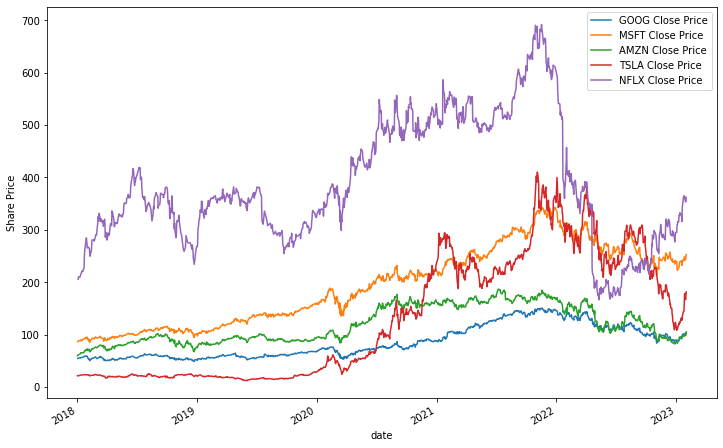

KeyError: ignored

In [66]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (12, 8))

#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


### Scale Data and Configure Training/Test Datasets 

In [67]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1]
data = data.drop(['ticker'],axis=1)
 
# features and target columns
print(data['target'])
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
print(target)
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 
train_split = 0.9
split_idx = int(np.ceil(len(X1)*train_split))
date_index = X_feat.index
 
X_train,X_test = X1[:split_idx],X1[split_idx:]
y_train,y_test = y1[:split_idx],y1[split_idx:]
X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
 
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

date
2018-01-03     87.110001
2018-01-04     88.190002
2018-01-05     88.279999
2018-01-08     88.220001
2018-01-09     87.820000
                 ...    
2023-01-26    248.160004
2023-01-27    242.710007
2023-01-30    247.809998
2023-01-31    252.750000
2023-02-01    264.600006
Name: target, Length: 1196, dtype: float64
[[0.00813638]
 [0.01232081]
 [0.0126695 ]
 ...
 [0.63076329]
 [0.64990317]
 [0.69581564]]
(1186, 10, 18) (1068, 10, 18) (118, 10, 18) (118, 1) (1068, 1)


### LSTM Model Architecture
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [ ]:
#LSTM Framework
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
#!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


34/34 [==============================] - 1s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012    
[0.0011851069284603, 0.0011851069284603]
{'n_hidden': 0, 'neurons_visible': 58, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 50, 'dropout2': 0.7, 'neurons_hidden2': 40, 'dropout3': 0.4, 'neurons_hidden3': 50}


## LSTM Model Testing

### Format Test Data to Reflect Training Data Format

In [ ]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(google_score))

### Evaluate LSTM Model Success on Test Data

In [ ]:
#test LSTM model using x_test and google test data
from keras.models import load_model
model = load_model(LSTM_model.h5)

## Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [ ]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### Forecasting with Prophet

In [ ]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='144 days', horizon='10 days', period='10 days')
  return df

In [ ]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqo22xr8/1kz031h4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqo22xr8/6oin4k73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6932', 'data', 'file=/tmp/tmptqo22xr8/1kz031h4.json', 'init=/tmp/tmptqo22xr8/6oin4k73.json', 'output', 'file=/tmp/tmptqo22xr8/prophet_model0kz6tixr/prophet_model-20230323185847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 189 forecasts with cutoffs between 2018-01-04 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/189 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmptqo22xr8/1t884rk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqo22xr8/y330p7_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11865', 'data', 'file=/tmp/tmptqo22xr8/1t884rk9.json', 'init=/tmp/tmptqo22xr8/y330p7_e.json', 'output', 'file=/tmp/tmptqo22xr8/prophet_modelt0r8wgud/prophet_model-20230323185851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:58:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqo22xr8/3c_eas6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqo22xr8/b_u0sgyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]

## Hybrid Model 

In [ ]:
Google_train_data.head()

,ds,yhat
0,2018-01-05,55.415025
1,2018-01-08,59.202429
2,2018-01-09,61.168499
3,2018-01-10,63.397143
4,2018-01-11,65.767038


### Define Training Data Using Ouputs from Standalone Models

In [ ]:
#combine prophet and lstm results into metamodel training set, keeping microsoft validation data separate
MSFT_train_data.head()

,ds,yhat
0,2018-01-05,82.302334
1,2018-01-08,83.492663
2,2018-01-09,84.110961
3,2018-01-10,84.665438
4,2018-01-11,85.331126


In [140]:
#LSTM Framework
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
#!pip install keras_tuner
import keras_tuner
#Hybrid model architecture and training
LR = 0.01
EPOCH = 100
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 8, activation = "relu", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = True))
hybrid.add(Dropout(0.5))
hybrid.add(LSTM(units = 12, activation = 'relu', return_sequences = True))
hybrid.add(Dropout(0.5))
hybrid.add(LSTM(units = 12))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
hybrid_history = hybrid.fit(X_train2, y_train2, epochs = 100, batch_size = 24, callbacks = [Early_stop])
hybrid.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/100


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - ETA: 0s - loss: 0.2203 - mae: 0.3824

1/1 [==============================] - 7s 7s/step - loss: 0.2203 - mae: 0.3824
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.1534 - mae: 0.2946

1/1 [==============================] - 0s 61ms/step - loss: 0.1534 - mae: 0.2946
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.1140 - mae: 0.2249

1/1 [==============================] - 0s 55ms/step - loss: 0.1140 - mae: 0.2249
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.0701 - mae: 0.1752

1/1 [==============================] - 0s 45ms/step - loss: 0.0701 - mae: 0.1752
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.0804 - mae: 0.2358

1/1 [==============================] - 0s 50ms/step - loss: 0.0804 - mae: 0.2358
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.1470 - mae: 0.3236

1/1 [==============================] - 0s 51ms/step - loss: 0.1470 - mae: 0.3236
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.1375 - mae: 0.3006

1/1 [==============================] - 0s 54ms/step - loss: 0.1375 - mae: 0.3006
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.0732 - mae: 0.2170

1/1 [==============================] - 0s 50ms/step - loss: 0.0732 - mae: 0.2170
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.0580 - mae: 0.1740

1/1 [==============================] - 0s 65ms/step - loss: 0.0580 - mae: 0.1740
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.0885 - mae: 0.2252

1/1 [==============================] - 0s 57ms/step - loss: 0.0885 - mae: 0.2252
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.1035 - mae: 0.1792

1/1 [==============================] - 0s 58ms/step - loss: 0.1035 - mae: 0.1792
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.0974 - mae: 0.1884

1/1 [==============================] - 0s 60ms/step - loss: 0.0974 - mae: 0.1884
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.0869 - mae: 0.1878

1/1 [==============================] - 0s 44ms/step - loss: 0.0869 - mae: 0.1878
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.0820 - mae: 0.1857

1/1 [==============================] - 0s 38ms/step - loss: 0.0820 - mae: 0.1857
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.0753 - mae: 0.1697

1/1 [==============================] - 0s 26ms/step - loss: 0.0753 - mae: 0.1697
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.0844 - mae: 0.1781

1/1 [==============================] - 0s 25ms/step - loss: 0.0844 - mae: 0.1781
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.0829 - mae: 0.1647

1/1 [==============================] - 0s 23ms/step - loss: 0.0829 - mae: 0.1647
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.0711 - mae: 0.1665

1/1 [==============================] - 0s 26ms/step - loss: 0.0711 - mae: 0.1665
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.0747 - mae: 0.1688

1/1 [==============================] - 0s 24ms/step - loss: 0.0747 - mae: 0.1688
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.0863 - mae: 0.1887

1/1 [==============================] - 0s 24ms/step - loss: 0.0863 - mae: 0.1887
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.0503 - mae: 0.1593

1/1 [==============================] - 0s 26ms/step - loss: 0.0503 - mae: 0.1593
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.0808 - mae: 0.2029

1/1 [==============================] - 0s 26ms/step - loss: 0.0808 - mae: 0.2029
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.0681 - mae: 0.2092

1/1 [==============================] - 0s 24ms/step - loss: 0.0681 - mae: 0.2092
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.0893 - mae: 0.2251

1/1 [==============================] - 0s 30ms/step - loss: 0.0893 - mae: 0.2251
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.0740 - mae: 0.2084

1/1 [==============================] - 0s 36ms/step - loss: 0.0740 - mae: 0.2084
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.0845 - mae: 0.2212

1/1 [==============================] - 0s 28ms/step - loss: 0.0845 - mae: 0.2212
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.0915 - mae: 0.2115

1/1 [==============================] - 0s 30ms/step - loss: 0.0915 - mae: 0.2115
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.0784 - mae: 0.2193

1/1 [==============================] - 0s 31ms/step - loss: 0.0784 - mae: 0.2193
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.0802 - mae: 0.2087

1/1 [==============================] - 0s 27ms/step - loss: 0.0802 - mae: 0.2087
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.0708 - mae: 0.2094

1/1 [==============================] - 0s 24ms/step - loss: 0.0708 - mae: 0.2094
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.0718 - mae: 0.1992

1/1 [==============================] - 0s 26ms/step - loss: 0.0718 - mae: 0.1992
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.0585 - mae: 0.1782

1/1 [==============================] - 0s 26ms/step - loss: 0.0585 - mae: 0.1782
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.0712 - mae: 0.2015

1/1 [==============================] - 0s 26ms/step - loss: 0.0712 - mae: 0.2015
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.0698 - mae: 0.1776

1/1 [==============================] - 0s 35ms/step - loss: 0.0698 - mae: 0.1776
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.0598 - mae: 0.1780

1/1 [==============================] - 0s 27ms/step - loss: 0.0598 - mae: 0.1780
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0696 - mae: 0.1730

1/1 [==============================] - 0s 23ms/step - loss: 0.0696 - mae: 0.1730
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.0689 - mae: 0.1819

1/1 [==============================] - 0s 26ms/step - loss: 0.0689 - mae: 0.1819
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0810 - mae: 0.1819

1/1 [==============================] - 0s 26ms/step - loss: 0.0810 - mae: 0.1819
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0624 - mae: 0.1571

1/1 [==============================] - 0s 27ms/step - loss: 0.0624 - mae: 0.1571
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0808 - mae: 0.1963

1/1 [==============================] - 0s 26ms/step - loss: 0.0808 - mae: 0.1963
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0685 - mae: 0.1744

1/1 [==============================] - 0s 30ms/step - loss: 0.0685 - mae: 0.1744
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0785 - mae: 0.1888

1/1 [==============================] - 0s 28ms/step - loss: 0.0785 - mae: 0.1888
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0485 - mae: 0.1544

1/1 [==============================] - 0s 24ms/step - loss: 0.0485 - mae: 0.1544
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0967 - mae: 0.2293

1/1 [==============================] - 0s 25ms/step - loss: 0.0967 - mae: 0.2293
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0758 - mae: 0.1947

1/1 [==============================] - 0s 26ms/step - loss: 0.0758 - mae: 0.1947
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0668 - mae: 0.1822

1/1 [==============================] - 0s 27ms/step - loss: 0.0668 - mae: 0.1822
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0834 - mae: 0.2068

1/1 [==============================] - 0s 25ms/step - loss: 0.0834 - mae: 0.2068
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0804 - mae: 0.1987

1/1 [==============================] - 0s 24ms/step - loss: 0.0804 - mae: 0.1987
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0600 - mae: 0.1681

1/1 [==============================] - 0s 27ms/step - loss: 0.0600 - mae: 0.1681
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0622 - mae: 0.1688

1/1 [==============================] - 0s 31ms/step - loss: 0.0622 - mae: 0.1688
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1621

1/1 [==============================] - 0s 27ms/step - loss: 0.0530 - mae: 0.1621
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0674 - mae: 0.1907

1/1 [==============================] - 0s 24ms/step - loss: 0.0674 - mae: 0.1907
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0611 - mae: 0.1785

1/1 [==============================] - 0s 29ms/step - loss: 0.0611 - mae: 0.1785
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0686 - mae: 0.1648

1/1 [==============================] - 0s 25ms/step - loss: 0.0686 - mae: 0.1648
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0809 - mae: 0.1937

1/1 [==============================] - 0s 32ms/step - loss: 0.0809 - mae: 0.1937
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0859 - mae: 0.1933

1/1 [==============================] - 0s 34ms/step - loss: 0.0859 - mae: 0.1933
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0687 - mae: 0.1799

1/1 [==============================] - 0s 29ms/step - loss: 0.0687 - mae: 0.1799
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0732 - mae: 0.1821

1/1 [==============================] - 0s 28ms/step - loss: 0.0732 - mae: 0.1821
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0724 - mae: 0.1928

1/1 [==============================] - 0s 26ms/step - loss: 0.0724 - mae: 0.1928
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0818 - mae: 0.2040

1/1 [==============================] - 0s 27ms/step - loss: 0.0818 - mae: 0.2040
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0602 - mae: 0.1778

1/1 [==============================] - 0s 26ms/step - loss: 0.0602 - mae: 0.1778
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0634 - mae: 0.1838

1/1 [==============================] - 0s 26ms/step - loss: 0.0634 - mae: 0.1838
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0693 - mae: 0.1761

1/1 [==============================] - 0s 30ms/step - loss: 0.0693 - mae: 0.1761
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0772 - mae: 0.1933

1/1 [==============================] - 0s 25ms/step - loss: 0.0772 - mae: 0.1933
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0667 - mae: 0.1754

1/1 [==============================] - 0s 27ms/step - loss: 0.0667 - mae: 0.1754
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0764 - mae: 0.1949

1/1 [==============================] - 0s 26ms/step - loss: 0.0764 - mae: 0.1949
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0665 - mae: 0.1764

1/1 [==============================] - 0s 26ms/step - loss: 0.0665 - mae: 0.1764
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0744 - mae: 0.1856

1/1 [==============================] - 0s 28ms/step - loss: 0.0744 - mae: 0.1856
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0669 - mae: 0.1811

1/1 [==============================] - 0s 26ms/step - loss: 0.0669 - mae: 0.1811
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0880 - mae: 0.2028

1/1 [==============================] - 0s 27ms/step - loss: 0.0880 - mae: 0.2028
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0775 - mae: 0.1923

1/1 [==============================] - 0s 30ms/step - loss: 0.0775 - mae: 0.1923
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0612 - mae: 0.1800

1/1 [==============================] - 0s 26ms/step - loss: 0.0612 - mae: 0.1800
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0702 - mae: 0.1781

1/1 [==============================] - 0s 30ms/step - loss: 0.0702 - mae: 0.1781
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0591 - mae: 0.1735

1/1 [==============================] - 0s 29ms/step - loss: 0.0591 - mae: 0.1735
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0772 - mae: 0.2000

1/1 [==============================] - 0s 29ms/step - loss: 0.0772 - mae: 0.2000
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0760 - mae: 0.1829

1/1 [==============================] - 0s 32ms/step - loss: 0.0760 - mae: 0.1829
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0761 - mae: 0.2050

1/1 [==============================] - 0s 26ms/step - loss: 0.0761 - mae: 0.2050
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0694 - mae: 0.1711

1/1 [==============================] - 0s 29ms/step - loss: 0.0694 - mae: 0.1711
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0772 - mae: 0.1810

1/1 [==============================] - 0s 26ms/step - loss: 0.0772 - mae: 0.1810
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0660 - mae: 0.1785

1/1 [==============================] - 0s 27ms/step - loss: 0.0660 - mae: 0.1785
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0722 - mae: 0.1841

1/1 [==============================] - 0s 26ms/step - loss: 0.0722 - mae: 0.1841
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0694 - mae: 0.1841

1/1 [==============================] - 0s 25ms/step - loss: 0.0694 - mae: 0.1841
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0687 - mae: 0.1819

1/1 [==============================] - 0s 34ms/step - loss: 0.0687 - mae: 0.1819
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0745 - mae: 0.1855

1/1 [==============================] - 0s 28ms/step - loss: 0.0745 - mae: 0.1855
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0759 - mae: 0.1847

1/1 [==============================] - 0s 29ms/step - loss: 0.0759 - mae: 0.1847
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0645 - mae: 0.1705

1/1 [==============================] - 0s 29ms/step - loss: 0.0645 - mae: 0.1705
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0618 - mae: 0.1768

1/1 [==============================] - 0s 33ms/step - loss: 0.0618 - mae: 0.1768
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0719 - mae: 0.1923

1/1 [==============================] - 0s 35ms/step - loss: 0.0719 - mae: 0.1923
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0700 - mae: 0.1871

1/1 [==============================] - 0s 31ms/step - loss: 0.0700 - mae: 0.1871
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0666 - mae: 0.1816

1/1 [==============================] - 0s 26ms/step - loss: 0.0666 - mae: 0.1816
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0637 - mae: 0.1832

1/1 [==============================] - 0s 38ms/step - loss: 0.0637 - mae: 0.1832
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0677 - mae: 0.1851

1/1 [==============================] - 0s 35ms/step - loss: 0.0677 - mae: 0.1851
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0760 - mae: 0.1882

1/1 [==============================] - 0s 24ms/step - loss: 0.0760 - mae: 0.1882
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0706 - mae: 0.1880

1/1 [==============================] - 0s 25ms/step - loss: 0.0706 - mae: 0.1880
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0605 - mae: 0.1783

1/1 [==============================] - 0s 25ms/step - loss: 0.0605 - mae: 0.1783
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0730 - mae: 0.1950

1/1 [==============================] - 0s 26ms/step - loss: 0.0730 - mae: 0.1950
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0720 - mae: 0.1879

1/1 [==============================] - 0s 25ms/step - loss: 0.0720 - mae: 0.1879
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0636 - mae: 0.1876

1/1 [==============================] - 0s 25ms/step - loss: 0.0636 - mae: 0.1876
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0636 - mae: 0.1786

1/1 [==============================] - 0s 28ms/step - loss: 0.0636 - mae: 0.1786
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0698 - mae: 0.1803

1/1 [==============================] - 0s 24ms/step - loss: 0.0698 - mae: 0.1803


#LOSS and MAE

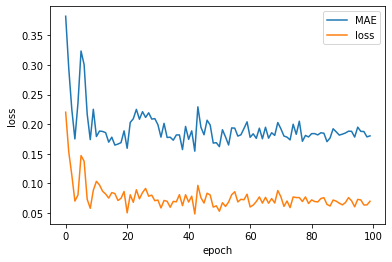

In [149]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Hybrid Model Testing

In [73]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  lstm_pred = lstm_pred.set_index('date')
  prophet_pred = prophet_pred.set_index('date')
  hybrid_test_data = pd.merge(lstm_pred, prophet_pred, left_index=True, right_index=True)
  return hybrid_test_data

In [37]:
hybrid_test_data= merge_predictions(google_lstm,google_prophet)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
google = frames[0]

#features and target columns
target_scaler = MinMaxScaler()
target_transformed = target_scaler.fit_transform(google['target'])
features = hybrid_test_data

# Normalise the data
for col in features.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    features[col] = scaler.fit_transform(features[[col]])

X_ft = np.array(features)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(1, steps):
      X.append(data[i-1:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(features,target_transformed,len(X_ft))

In [ ]:
predictions = hybrid.predict(X1)

In [153]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [157]:
mse, mae = compute_metrics(y1, predictions)
print(mae)

[0.25862074 0.29496095 0.21489815 0.2044707  0.19523767 0.17672819
 0.16752344 0.15696163 0.14508063 0.12658183 0.1094318  0.10154802
 0.58054215 0.07185179 0.7287806  0.04668623 0.03819741 0.01571554
 0.00786436 0.10600939 0.02269244 0.02773663 0.04625782 0.05810237
 0.7388468  0.08801049 0.1016244  0.11082825 0.12005687 0.19815978]


#Predicted vs Actual Price

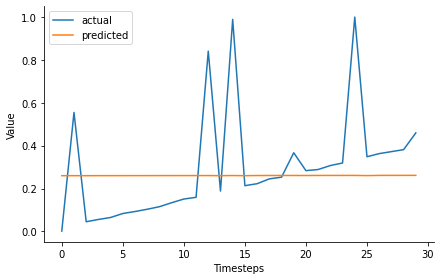

In [165]:

plt.plot(y1, label="actual")
plt.plot(predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

# Multiple Company Model

## Generate Sub-models

In [ ]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in list_of_df:
    data = frames[i]
    score = data['score']
    target = data['target']
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    scaler = MinMaxScaler()
    for col in training.columns:
      training[col] = scaler.fit_transform(training[col])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, 10)
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train, ticker):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 8, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True))
    hybrid.add(Dropout(0.5))
    hybrid.add(LSTM(units = 12, activation = 'relu', return_sequences = True))
    hybrid.add(Dropout(0.5))
    hybrid.add(LSTM(units = 12))
    hybrid.add(Dropout(0.5))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames)
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(tick, x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/Models/'+tick+'_lstm.h5')


## Configure Hybrid Training Set and Train Hybrid Model

In [ ]:
import os
def hybrid_train(direct, ticker_list, hybrid_train):
    preds_dict = {}
    path = direct
    for num, model in enumerate(os.listdir(path)):
        model = load_model(model)
        prediction = model.predict(hybrid_train)
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DatFrame(preds_dict)
    return preds_df

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data =  hybrid_train('/content/StockPrice-Hybrid-Model-/Models/', ticker_list, X_train) 
hybrid_expanded = multiple_models(hybrid_training_data, y_train)

## Test the Expanded Model

In [ ]:
from os import listdir
google_test = {}
microsoft_test = {}
path = '/models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(model)
  goog_preds = model.predict(google_ft)
  micro_preds = model.predict(X_test)
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)